# Model Comparison: Faster R-CNN vs. YOLOv9

This notebook provides a comprehensive, side-by-side evaluation of two object detection models trained for a parking lot detection task:
1. **Faster R-CNN (ResNet-50 FPN)**
2. **YOLOv9-C**

The goal is to perform a fair comparison using a standardized set of metrics to determine which model is better suited for this task.

## Evaluation Metrics

Both models will be evaluated on the following criteria:

- **Object Detection Performance:**
  - **mAP@0.5:0.95:** Mean Average Precision over IoU thresholds from 0.5 to 0.95.
  - **mAP@0.5:** Mean Average Precision at a single IoU threshold of 0.5.
  - **Precision:** The accuracy of the positive predictions.
  - **Recall:** The ability of the model to find all the relevant objects.

- **Counting Performance:**
  - **Exact Accuracy:** The percentage of images where the predicted count exactly matches the ground truth count.
  - **Mean Absolute Error (MAE):** The average absolute difference between predicted and ground truth counts.

- **Inference Speed:**
  - **Frames Per Second (FPS):** The number of images the model can process per second.

## 1. Global Configuration and Setup

In [1]:
import torch
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import json
from pathlib import Path
import time
import pandas as pd
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
import os
import sys
import subprocess
import yaml
import re
import shutil

warnings.filterwarnings('ignore')

# --- General Configuration ---
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SCORE_THRESHOLD = 0.5 # For counting and visualization

# --- Faster R-CNN Configuration ---
RCNN_BASE_DIR = Path('./rcnn/')
RCNN_RUN_DIR = RCNN_BASE_DIR / 'runs' / 'rcnn'
RCNN_MODEL_CHECKPOINT = RCNN_RUN_DIR / 'latest.pt'
RCNN_DATA_DIR = RCNN_BASE_DIR / 'data'
RCNN_TEST_JSON = RCNN_DATA_DIR / 'test.json'
RCNN_TEST_IMG_DIR = RCNN_DATA_DIR / 'test'
RCNN_NUM_CLASSES = 2
RCNN_BATCH_SIZE = 4

# --- YOLOv9 Configuration ---
YOLO_BASE_DIR = Path('./yolo/')
YOLO_RUN_DIR = YOLO_BASE_DIR / 'runs' / 'train' / 'carpk_yolov9'
YOLO_MODEL_CHECKPOINT = YOLO_RUN_DIR / 'weights' / 'best.pt'
YOLO_DATA_YAML = YOLO_BASE_DIR / 'prepared_data' / 'yolo' / 'data.yaml'
YOLOv9_DIR = YOLO_BASE_DIR / 'yolov9'
YOLO_IMG_SIZE = 640
YOLO_CONF_THRESHOLD = 0.25
YOLO_IOU_THRESHOLD = 0.7
YOLO_DEVICE = '0' if torch.cuda.is_available() else 'cpu'

# --- File and Directory Checks ---
def check_paths():
    paths_to_check = {
        "R-CNN Model": RCNN_MODEL_CHECKPOINT,
        "R-CNN Test JSON": RCNN_TEST_JSON,
        "R-CNN Test Images": RCNN_TEST_IMG_DIR,
        "YOLOv9 Model": YOLO_MODEL_CHECKPOINT,
        "YOLOv9 Data YAML": YOLO_DATA_YAML,
        "YOLOv9 Repo": YOLOv9_DIR / 'val.py',
    }
    all_found = True
    for name, path in paths_to_check.items():
        if not path.exists():
            print(f" ERROR: {name} not found at: {path}")
            all_found = False
        else:
            print(f" Found {name}")
    if not all_found:
        raise FileNotFoundError("One or more required files/directories not found.")

print(f"Using device: {DEVICE}")
check_paths()

Using device: cuda
 Found R-CNN Model
 Found R-CNN Test JSON
 Found R-CNN Test Images
 Found YOLOv9 Model
 Found YOLOv9 Data YAML
 Found YOLOv9 Repo


## 2. Faster R-CNN Evaluation

First, we will evaluate the performance of the Faster R-CNN model.

In [2]:
# --- R-CNN Helper Functions ---

def get_rcnn_model(num_classes, anchor_sizes=None):
    try:
        model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(weights=None)
    except AttributeError:
        model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=None)
    
    if anchor_sizes is not None:
        aspect_ratios = ((0.5, 1.0, 2.0),) * len(anchor_sizes)
        anchor_generator = AnchorGenerator(sizes=anchor_sizes, aspect_ratios=aspect_ratios)
        model.rpn.anchor_generator = anchor_generator
    
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

class COCODataset(torch.utils.data.Dataset):
    def __init__(self, json_file, img_dir, transforms=None):
        from pycocotools.coco import COCO
        self.img_dir = Path(img_dir)
        self.transforms = transforms
        self.coco = COCO(str(json_file))
        self.ids = list(sorted(self.coco.imgs.keys()))
    
    def __getitem__(self, index):
        img_id = self.ids[index]
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        coco_anns = self.coco.loadAnns(ann_ids)
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = self.img_dir / img_info['file_name']
        img = Image.open(img_path).convert('RGB')
        
        boxes, labels = [], []
        for ann in coco_anns:
            x, y, w, h = ann['bbox']
            if w <= 0 or h <= 0: continue
            boxes.append([x, y, x + w, y + h])
            labels.append(ann['category_id'])
        
        target = {
            "boxes": torch.as_tensor(boxes, dtype=torch.float32) if boxes else torch.zeros((0, 4), dtype=torch.float32),
            "labels": torch.as_tensor(labels, dtype=torch.int64) if labels else torch.zeros(0, dtype=torch.int64),
            "image_id": torch.tensor([img_id])
        }
        
        if self.transforms:
            img_tensor = self.transforms(img)
        
        return img_tensor, target, img
    
    def __len__(self):
        return len(self.ids)

def get_transform():
    return torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

def collate_fn(batch):
    return tuple(zip(*batch))

In [3]:
# --- R-CNN Evaluation Functions ---

@torch.no_grad()
def evaluate_rcnn_coco(model, data_loader, device, coco_gt):
    from pycocotools.cocoeval import COCOeval
    model.eval()
    coco_results = []
    
    for images, targets, _ in tqdm(data_loader, desc="R-CNN: Running detection"):
        images = [img.to(device) for img in images]
        outputs = model(images)
        
        for target, output in zip(targets, outputs):
            image_id = target['image_id'].item()
            boxes, scores, labels = output['boxes'].cpu().numpy(), output['scores'].cpu().numpy(), output['labels'].cpu().numpy()
            
            mask = scores > 0.05
            boxes, scores, labels = boxes[mask], scores[mask], labels[mask]
            
            for box, score, label in zip(boxes, scores, labels):
                if label == 0: continue
                x1, y1, x2, y2 = box
                w, h = x2 - x1, y2 - y1
                if w <= 0 or h <= 0: continue
                coco_results.append({
                    'image_id': int(image_id), 'category_id': 1,
                    'bbox': [float(x1), float(y1), float(w), float(h)], 'score': float(score)
                })
                
    if not coco_results: return None
    if 'info' not in coco_gt.dataset: coco_gt.dataset['info'] = []
        
    coco_dt = coco_gt.loadRes(coco_results)
    coco_eval = COCOeval(coco_gt, coco_dt, 'bbox')
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()
    
    return {
        'map_50_95': coco_eval.stats[0],
        'map_50': coco_eval.stats[1],
        'precision': coco_eval.stats[0], # Using mAP as proxy
        'recall': coco_eval.stats[8] # AR@100
    }

@torch.no_grad()
def calculate_rcnn_counting_metrics(model, data_loader, device, score_threshold):
    model.eval()
    results = []
    for images, targets, _ in tqdm(data_loader, desc="R-CNN: Calculating counting metrics"):
        images = [img.to(device) for img in images]
        outputs = model(images)
        for i in range(len(images)):
            gt_count = len(targets[i]['labels'])
            pred_count = (outputs[i]['scores'] > score_threshold).sum().item()
            results.append({'gt_count': gt_count, 'pred_count': pred_count, 'abs_error': abs(pred_count - gt_count)})
    
    df = pd.DataFrame(results)
    exact_accuracy = ((df['pred_count'] == df['gt_count']).sum() / len(df)) * 100
    mae = df['abs_error'].mean()
    return {'count_accuracy': exact_accuracy, 'count_mae': mae}

@torch.no_grad()
def calculate_rcnn_fps(model, data_loader, device):
    model.eval()
    # Warm-up
    for i, (images, _, _) in enumerate(data_loader):
        if i >= 3: break
        images = [img.to(device) for img in images]
        _ = model(images)

    total_time, num_images = 0, 0
    for images, _, _ in tqdm(data_loader, desc="R-CNN: Measuring inference speed"):
        images = [img.to(device) for img in images]
        start_time = time.time()
        _ = model(images)
        torch.cuda.synchronize() if device.type == 'cuda' else None
        total_time += (time.time() - start_time)
        num_images += len(images)
    return num_images / total_time if total_time > 0 else 0

def evaluate_rcnn():
    """Main function to run all evaluations for Faster R-CNN."""
    print("--- Starting Faster R-CNN Evaluation ---")
    # Load model
    args_file = RCNN_RUN_DIR / 'args.json'
    anchor_sizes = None
    if args_file.exists():
        with open(args_file, 'r') as f: train_args = json.load(f)
        if train_args.get('anchor_sizes'):
            anchor_sizes = tuple(tuple([int(s)]) for s in train_args['anchor_sizes'].split(','))
    
    rcnn_model = get_rcnn_model(num_classes=RCNN_NUM_CLASSES, anchor_sizes=anchor_sizes)
    checkpoint = torch.load(RCNN_MODEL_CHECKPOINT, map_location=DEVICE)
    rcnn_model.load_state_dict(checkpoint['model_state_dict'])
    rcnn_model.to(DEVICE)
    rcnn_model.eval()
    print("R-CNN model loaded successfully.")

    # Load data
    test_dataset = COCODataset(RCNN_TEST_JSON, RCNN_TEST_IMG_DIR, transforms=get_transform())
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=RCNN_BATCH_SIZE, shuffle=False, num_workers=0, collate_fn=collate_fn)
    print(f"Test dataset: {len(test_dataset)} images")

    # Run evaluations
    bbox_metrics = evaluate_rcnn_coco(rcnn_model, test_loader, DEVICE, test_dataset.coco)
    counting_metrics = calculate_rcnn_counting_metrics(rcnn_model, test_loader, DEVICE, SCORE_THRESHOLD)
    fps = calculate_rcnn_fps(rcnn_model, test_loader, DEVICE)

    # Combine results
    rcnn_results = {
        **(bbox_metrics if bbox_metrics else {}),
        **(counting_metrics if counting_metrics else {}),
        'fps': fps
    }
    print("--- Faster R-CNN Evaluation Complete ---")
    return rcnn_results, rcnn_model, test_dataset

# Run R-CNN evaluation
rcnn_results, rcnn_model, rcnn_test_dataset = evaluate_rcnn()

--- Starting Faster R-CNN Evaluation ---
R-CNN model loaded successfully.
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Test dataset: 99 images


R-CNN: Running detection: 100%|██████████| 25/25 [00:14<00:00,  1.69it/s]


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.09s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.770
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.988
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.951
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.328
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.771
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.783
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.019
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.192
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.818
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

R-CNN: Measuring inference speed: 100%|██████████| 25/25 [00:14<00:00,  1.68it/s]

--- Faster R-CNN Evaluation Complete ---


## 3. YOLOv9 Evaluation

Next, we evaluate the YOLOv9 model. This involves running the official `val.py` and `detect.py` scripts from the YOLOv9 repository.

In [4]:
# --- YOLOv9 Helper and Evaluation Functions (FIXED PATHS) ---

def patch_yolov9_detect_script():
    detect_script_path = YOLOv9_DIR / 'detect.py'
    patch_signature = "# PATCHED: Handle list output from model"
    if not detect_script_path.exists():
        print(f"Warning: {detect_script_path} not found.")
        return
    with open(detect_script_path, 'r', encoding='utf-8') as f: lines = f.readlines()
    if any(patch_signature in line for line in lines): return

    print(f"Applying patch to {detect_script_path}...")
    new_lines = []
    for line in lines:
        new_lines.append(line)
        if 'pred = model(im, augment=augment, visualize=visualize)' in line:
            indent = ' ' * (len(line) - len(line.lstrip()))
            new_lines.append(f"{indent}{patch_signature}\n")
            new_lines.append(f"{indent}if isinstance(pred, list): pred = pred[0]\n")
    with open(detect_script_path, 'w', encoding='utf-8') as f: f.writelines(new_lines)
    print("Patch applied successfully.")

def run_yolo_validation():
    original_dir = Path.cwd()
    
    # FIX: Use absolute paths for all arguments to avoid resolution errors
    data_path_abs = str(YOLO_DATA_YAML.resolve())
    weights_path_abs = str(YOLO_MODEL_CHECKPOINT.resolve())
    
    os.chdir(YOLOv9_DIR)
    cmd = [sys.executable, 'val.py', '--data', data_path_abs, '--weights', weights_path_abs,
           '--img', str(YOLO_IMG_SIZE), '--conf-thres', '0.001', '--iou-thres', str(YOLO_IOU_THRESHOLD),
           '--device', YOLO_DEVICE, '--task', 'test', '--verbose']
    print("YOLOv9: Running validation...")
    result = subprocess.run(cmd, capture_output=True, text=True, encoding='utf-8')
    os.chdir(original_dir)
    if result.returncode != 0: print(f"Validation failed: \n{result.stderr}")
    return result.stdout + "\n" + result.stderr

def parse_yolo_validation_output(output):
    metrics = {}
    line = re.search(r"all\s+\d+\s+\d+\s+([\d\.]+)\s+([\d\.]+)\s+([\d\.]+)\s+([\d\.]+)", output)
    if line: metrics.update({'precision': float(line.group(1)), 'recall': float(line.group(2)), 'map_50': float(line.group(3)), 'map_50_95': float(line.group(4))})
    for pattern in [r"Speed:.*?([\d\.]+)ms\s+inference", r"inference:\s*([\d\.]+)ms", r"([\d\.]+)ms.*?inference"]:
        speed = re.search(pattern, output, re.IGNORECASE)
        if speed and float(speed.group(1)) > 0: metrics['fps'] = 1000.0 / float(speed.group(1)); break
    return metrics

def get_yolo_test_dirs():
    with open(YOLO_DATA_YAML.resolve(), 'r') as f: data_config = yaml.safe_load(f)
    test_path_str = data_config.get('test', '')
    test_path_abs = (YOLO_DATA_YAML.resolve().parent / test_path_str).resolve()
    return test_path_abs, test_path_abs.parent / 'labels'

def run_yolo_detection():
    original_dir = Path.cwd()
    test_img_dir, _ = get_yolo_test_dirs()
    project_dir = YOLO_BASE_DIR / 'runs' / 'detect_for_counting'
    if project_dir.exists(): shutil.rmtree(project_dir)
    
    # FIX: Use absolute paths for all arguments
    weights_path_abs = str(YOLO_MODEL_CHECKPOINT.resolve())
    source_path_abs = str(test_img_dir.resolve())
    project_path_abs = str(project_dir.resolve())
    
    os.chdir(YOLOv9_DIR)
    cmd = [sys.executable, 'detect.py', '--weights', weights_path_abs, '--source', source_path_abs,
           '--img', str(YOLO_IMG_SIZE), '--conf', str(YOLO_CONF_THRESHOLD), '--iou-thres', str(YOLO_IOU_THRESHOLD),
           '--device', YOLO_DEVICE, '--save-txt', '--project', project_path_abs, '--name', 'exp']
    print("YOLOv9: Running detection for counting...")
    try: subprocess.run(cmd, check=True, capture_output=True, text=True, encoding='utf-8')
    except subprocess.CalledProcessError as e: print(f"Detection failed: \n{e.stderr}")
    finally: os.chdir(original_dir)
    return project_dir / 'exp' / 'labels'

def calculate_yolo_counting_metrics(pred_label_dir):
    test_img_dir, gt_label_dir = get_yolo_test_dirs()
    test_images = list(test_img_dir.glob('*.jpg')) + list(test_img_dir.glob('*.png'))
    results = []
    for img_path in tqdm(test_images, desc="YOLOv9: Calculating counting metrics"):
        gt_label_path = gt_label_dir / f"{img_path.stem}.txt"
        pred_label_path = pred_label_dir / f"{img_path.stem}.txt"
        gt_count = sum(1 for line in open(gt_label_path) if line.strip()) if gt_label_path.exists() else 0
        pred_count = sum(1 for line in open(pred_label_path) if line.strip()) if pred_label_path.exists() else 0
        results.append({'gt_count': gt_count, 'pred_count': pred_count, 'abs_error': abs(pred_count - gt_count)})
    if not results: return {'count_accuracy': 0, 'count_mae': float('inf')}
    df = pd.DataFrame(results)
    exact_accuracy = ((df['pred_count'] == df['gt_count']).sum() / len(df)) * 100
    mae = df['abs_error'].mean()
    return {'count_accuracy': exact_accuracy, 'count_mae': mae}

def evaluate_yolo():
    """Main function to run all evaluations for YOLOv9."""
    print("--- Starting YOLOv9 Evaluation ---")
    patch_yolov9_detect_script()
    
    # Run evaluations
    validation_output = run_yolo_validation()
    bbox_metrics = parse_yolo_validation_output(validation_output)
    
    # Only run counting if validation was at least partially successful
    counting_metrics = {}
    if bbox_metrics:
        pred_label_dir = run_yolo_detection()
        if pred_label_dir.exists():
             counting_metrics = calculate_yolo_counting_metrics(pred_label_dir)
        else:
            print("Skipping counting metrics because detection script failed to produce labels.")
    else:
        print("Skipping counting metrics because validation script failed.")

    yolo_results = {**(bbox_metrics if bbox_metrics else {}), **(counting_metrics if counting_metrics else {})}
    print("--- YOLOv9 Evaluation Complete ---")
    return yolo_results

# Run YOLOv9 evaluation
yolo_results = evaluate_yolo()

--- Starting YOLOv9 Evaluation ---
YOLOv9: Running validation...
YOLOv9: Running detection for counting...


YOLOv9: Calculating counting metrics: 100%|██████████| 164/164 [00:00<00:00, 557.53it/s]

--- YOLOv9 Evaluation Complete ---


## 4. Results Comparison

Now we'll consolidate the results from both models and display them in a comparison table and a series of charts.

In [5]:
# Consolidate results into a DataFrame for easy comparison
metrics_data = {'Faster R-CNN': rcnn_results, 'YOLOv9': yolo_results}
df_results = pd.DataFrame(metrics_data).T

# Define standard metric columns for consistent ordering and format
metric_cols = ['map_50_95', 'map_50', 'precision', 'recall', 'count_mae', 'count_accuracy', 'fps']
df_results = df_results.reindex(columns=metric_cols).fillna(0)

# Format the DataFrame for better readability
styled_df = df_results.style.format({
    'map_50_95': '{:.4f}',
    'map_50': '{:.4f}',
    'precision': '{:.4f}',
    'recall': '{:.4f}',
    'count_mae': '{:.4f}',
    'count_accuracy': '{:.2f}%',
    'fps': '{:.2f}'
}).set_caption("Model Performance Comparison").set_table_styles([{'selector': 'caption', 'props': [('font-size', '16px'), ('font-weight', 'bold')]}])

print("====================================================")
print("           PERFORMANCE COMPARISON SUMMARY           ")
print("====================================================")
display(styled_df)

           PERFORMANCE COMPARISON SUMMARY           


,map_50_95,map_50,precision,recall,count_mae,count_accuracy,fps
Faster R-CNN,0.7696,0.9881,0.7696,0.8177,1.4747,25.25%,7.81
YOLOv9,0.8710,0.9940,0.9920,0.9960,0.6585,61.59%,28.99


### Visual Comparison

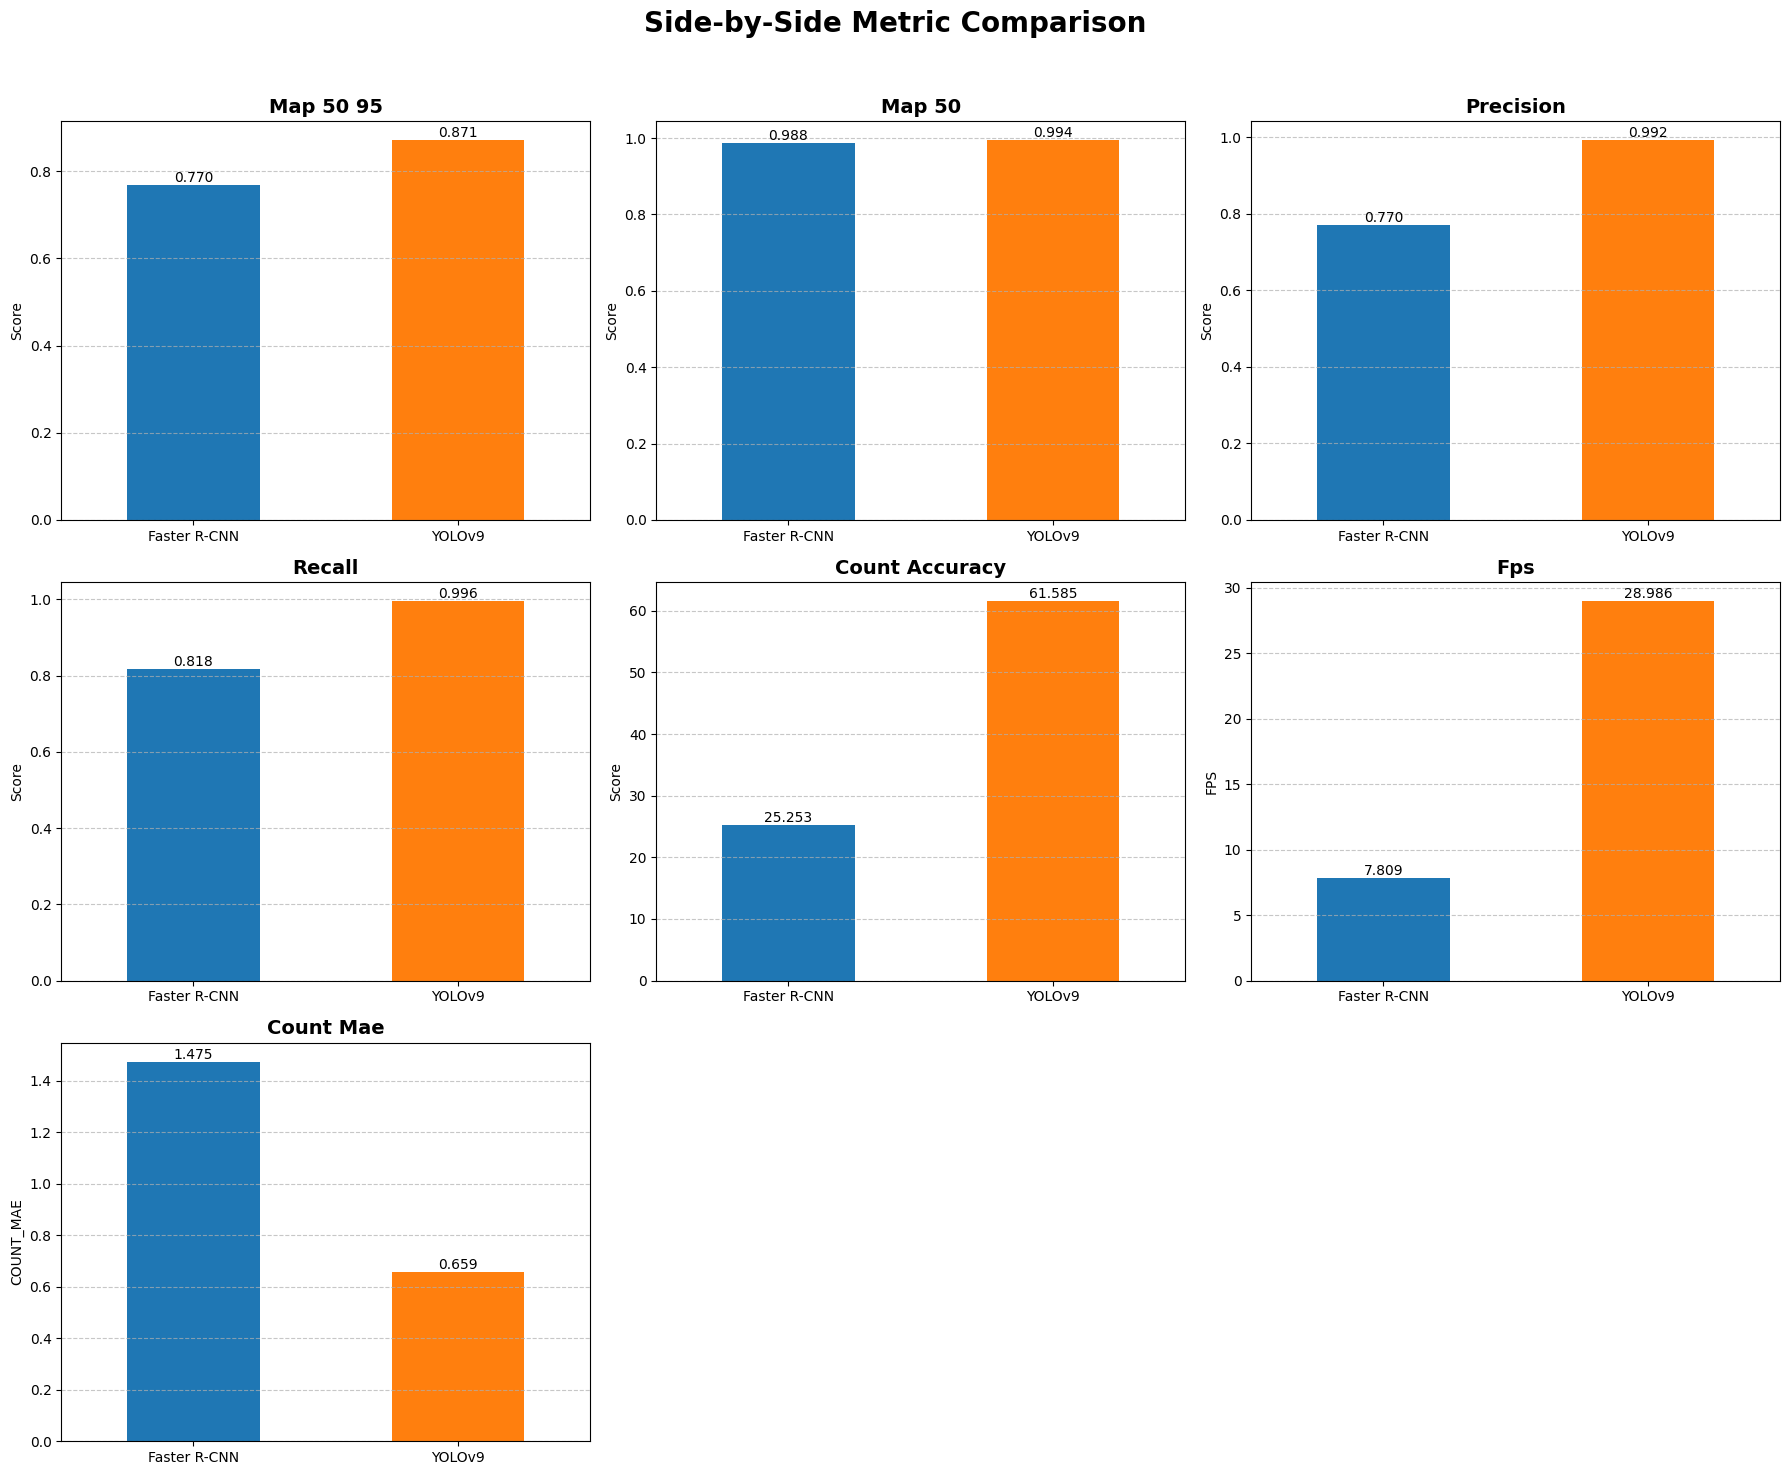

In [6]:
def plot_comparison_charts(df):
    """Generates bar charts to compare model performance on key metrics."""
    # Metrics where higher is better
    higher_better_metrics = ['map_50_95', 'map_50', 'precision', 'recall', 'count_accuracy', 'fps']
    # Metrics where lower is better
    lower_better_metrics = ['count_mae']
    
    all_metrics = higher_better_metrics + lower_better_metrics
    
    n_metrics = len(all_metrics)
    n_cols = 3
    n_rows = (n_metrics + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 5))
    axes = axes.flatten()
    
    for i, metric in enumerate(all_metrics):
        ax = axes[i]
        is_higher_better = metric in higher_better_metrics
        colors = ['#1f77b4' if is_higher_better else '#d62728', '#ff7f0e' if is_higher_better else '#d62728']
        
        bars = df[metric].plot(kind='bar', ax=ax, color=['#1f77b4', '#ff7f0e'], rot=0)
        ax.set_title(metric.replace('_', ' ').title(), fontsize=14, fontweight='bold')
        ax.set_ylabel('Score' if 'fps' not in metric and 'mae' not in metric else metric.upper())
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        
        for bar in bars.patches:
            yval = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.3f}', va='bottom', ha='center')
    
    # Hide any unused subplots
    for i in range(n_metrics, len(axes)):
        axes[i].set_visible(False)
        
    plt.suptitle('Side-by-Side Metric Comparison', fontsize=20, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

plot_comparison_charts(df_results)